# Getting Started:
## A simple driving model training and evaluation pipeline using the Drive360 dataset and PyTorch.

## Loading data from Drive360 dataset.

The **dataset.py** file contains the 3 classes necessary for creating a Drive360Loader. Using the **config.json** file to specify the location of the csv and data directory, we can generate phase (train, validation, test) specific data loaders that can output samples from each set. Adjust the **dataset.py** to your preferred training framework.

In [1]:
import json
from dataset import Drive360Loader

# load the config.json file that specifies data 
# location parameters and other hyperparameters 
# required.
config = json.load(open('./config.json'))

# create a train, validation and test data loader
train_loader = Drive360Loader(config, 'train')
validation_loader = Drive360Loader(config, 'validation')
test_loader = Drive360Loader(config, 'test')

# print the data (keys) available for use. See full 
# description of each data type in the documents.
print('Loaded train loader with the following data available as a dict.')
print(train_loader.drive360.dataframe.keys())

Phase: train # of data: 38876
Phase: validation # of data: 2558
Phase: test # of data: 6957
Loaded train loader with the following data available as a dict.
Index(['cameraRight', 'cameraFront', 'cameraRear', 'cameraLeft', 'canSteering',
       'canSpeed', 'chapter'],
      dtype='object')


## Training a basic driving model

Create your driving model. This is specific to your learning framework. 

Below we give a very basic dummy model that uses the front facing camera and a resnet34 + LSTM architecture to predict canSteering and canSpeed. 

In [2]:
from torchvision import models
import torch.nn as nn
import torch

class SomeDrivingModelResnet101(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet101, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet101(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction
    
class SomeDrivingModelResnet50(nn.Module):
    def __init__(self):
        super(SomeDrivingModelResnet50, self).__init__()
        final_concat_size = 0
        
        # Main CNN
        cnn = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(cnn.children())[:-1])
        self.intermediate = nn.Sequential(nn.Linear(
                          cnn.fc.in_features, 128),
                          nn.ReLU())
        final_concat_size += 128

        # Main LSTM
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=64,
                            num_layers=3,
                            batch_first=False)
        final_concat_size += 64
        
        # Angle Regressor
        self.control_angle = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Speed Regressor
        self.control_speed = nn.Sequential(
            nn.Linear(final_concat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, data):
        module_outputs = []
        lstm_i = []
        # Loop through temporal sequence of
        # front facing camera images and pass 
        # through the cnn.
        for k, v in data['cameraFront'].items():
            v = v.cuda()
            x = self.features(v)
            x = x.view(x.size(0), -1)
            x = self.intermediate(x)
            lstm_i.append(x)
            # feed the current front facing camera
            # output directly into the 
            # regression networks.
            if k == 0:
                module_outputs.append(x)

        # Feed temporal outputs of CNN into LSTM
        i_lstm, _ = self.lstm(torch.stack(lstm_i))
        module_outputs.append(i_lstm[-1])
        
        # Concatenate current image CNN output 
        # and LSTM output.
        x_cat = torch.cat(module_outputs, dim=-1)
        
        # Feed concatenated outputs into the 
        # regession networks.
        prediction = {'canSteering': torch.squeeze(self.control_angle(x_cat)),
                      'canSpeed': torch.squeeze(self.control_speed(x_cat))}
        return prediction

A basic training procedure that iterates over the train_loader and feeds each sample into our dummy model, subsequently calculates loss. We kill after 20 batches just

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion_speed, criterion_steering, epochs):
    hist_train_loss_speed = []
    hist_train_loss_steering = []
    hist_train_loss_total = []
    model.cuda()
    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            prediction = model(data)

            steering_loss = criterion_steering(prediction['canSteering'].cuda(), target['canSteering'].cuda())
            speed_loss = criterion_speed(prediction['canSpeed'].cuda(), target['canSpeed'].cuda())
            loss = steering_loss + speed_loss
            hist_train_loss_total.append(loss.cpu().detach().numpy())
            hist_train_loss_speed.append(speed_loss.cpu().detach().numpy())
            hist_train_loss_steering.append(steering_loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
        end = time.time() 
        print("Training minutes elapsed epoch{}: {}".format(epoch, round((end - start) / 60, 2)))

        model.eval()

        speed_sum = 0
        steering_sum = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(validation_loader):
                optimizer.zero_grad()
                prediction = model(data)
                speed_dif = prediction['canSpeed'].cpu() - target['canSpeed']
                steering_dif = prediction['canSteering'].cpu() - target['canSteering']
                speed_sum += (np.square(speed_dif)).mean()
                steering_sum += (np.square(steering_dif)).mean()
        print("Steering Error: {}\nSpeed Error: {}".format(float(steering_sum), float(speed_sum)))
    
    plt.plot(hist_train_loss_speed)
    plt.title("Speed Loss")
    plt.show()
    plt.plot(hist_train_loss_steering)
    plt.title("Steering Loss")
    plt.show()
    plt.plot(hist_train_loss_total)
    plt.title("Total Loss")
    plt.show()

## Local evaluation of the model.

In [4]:
def cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, index, name):
    print(name + ": ")
    train_model(user_models[index], optimizers[index], criterion_speeds[index], criterion_steerings[index], 5)
    print("--------------------------------------------------------------")

(Resnet50 Model, AdamW optimizer, SmoothL1Loss): 
Training minutes elapsed epoch0: 5.02
Steering Error: 5.284323692321777
Speed Error: 4.823840618133545
Training minutes elapsed epoch1: 5.02
Steering Error: 4.924598217010498
Speed Error: 4.2693891525268555


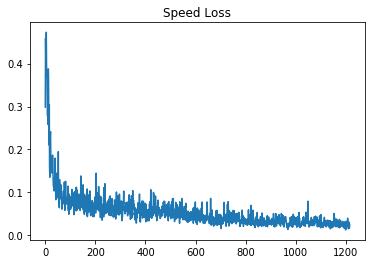

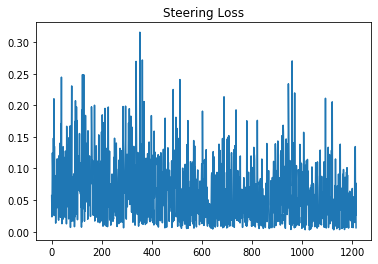

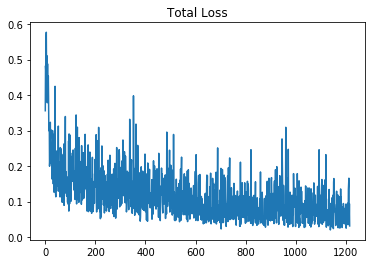

--------------------------------------------------------------


In [5]:
import torch.optim as optim

user_models = [SomeDrivingModelResnet50(), SomeDrivingModelResnet50(), SomeDrivingModelResnet101(), SomeDrivingModelResnet50()]
optimizers = [optim.SGD(user_models[0].parameters(), lr=0.0001, momentum=0.9),
             optim.SGD(user_models[1].parameters(), lr=0.0001, momentum=0.9),
             optim.AdamW(user_models[2].parameters(), lr=0.0001),
             optim.AdamW(user_models[3].parameters(), lr=0.001)]
criterion_speeds = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]
criterion_steerings = [nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss(), nn.SmoothL1Loss()]

# Resnet50 model + Adam
#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 0, 
#                 "(Default Model, SGD optimizer, SmoothL1Loss)")

# Resnet50 model + Adam
#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 1, 
#                 "(Resnet50 Model, SGD optimizer, SmoothL1Loss)")

#cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 2, 
#                 "(Resnet101 Model, AdamW optimizer, SmoothL1Loss)")

# Resnet50 model + Adam
cross_validation(user_models, optimizers, criterion_speeds, criterion_steerings, 3, 
                 "(Resnet50 Model, AdamW optimizer, SmoothL1Loss)")

## Creating a submission file.

In [6]:
normalize_targets = config['target']['normalize']
target_mean = config['target']['mean']
target_std = config['target']['std']

def add_results(results, output):
    steering = np.squeeze(output['canSteering'].cpu().data.numpy())
    speed = np.squeeze(output['canSpeed'].cpu().data.numpy())
    if normalize_targets:
        steering = (steering*target_std['canSteering'])+target_mean['canSteering']
        speed = (speed*target_std['canSpeed'])+target_mean['canSpeed']
    if np.isscalar(steering):
        steering = [steering]
    if np.isscalar(speed):
        speed = [speed]
    results['canSteering'].extend(steering)
    results['canSpeed'].extend(speed)


We use pandas to create a submission file which is simply a 2-column csv with a canSteering and canSpeed prediction for each row in the **drive360_test.csv** a total of 305437 rows/predictions not including the header. See the **sample_submission.csv** file as an example.

IMPORTANT: for the test phase indices will start 10s (100 samples) into each chapter this is to allow challenge participants to experiment with different temporal settings of data input. If challenge participants have a greater temporal length than 10s for each training sample, then they must write a custom function here. Please check out the **dataset.py** file for additional explanation.

In [7]:
import pandas as pd

def create_submission(model_index, interval):
    file = './submission.csv'
    results = {'canSteering': [],
               'canSpeed': []}

    final_result = {'canSteering': np.zeros(279863, dtype="float64"),
                    'canSpeed': np.zeros(279863, dtype="float64")}
    final_result['canSteering'][:] = np.nan
    final_result['canSpeed'][:] = np.nan


    start = time.time()
    print("Start creating submission file")
    with torch.no_grad():
        counter = 1
        for batch_idx, (data, target) in enumerate(test_loader):
            prediction = user_models[model_index](data)
            add_results(results, prediction)

    for i in range(len(results['canSteering'])):
        final_result['canSteering'][i*interval+19] = results['canSteering'][i]
        final_result['canSpeed'][i*interval+19] = results['canSpeed'][i]
    print("Total number of predictions (without trailing extrapolation): {}".format((i+1)*interval))    
    
    #Fill the first rows
    for i in range(20):
        final_result['canSteering'][i] = results['canSteering'][0]
        final_result['canSpeed'][i] = results['canSpeed'][0]

    df = pd.DataFrame.from_dict(final_result, dtype='float64')
    print("Start extrapolating submission file")
    df.interpolate(method='linear', limit_direction='forward', inplace=True)
    df.to_csv(file, index=False)

    end = time.time() 
    print("Minutes elapsed: {}".format(round((end - start) / 60, 2)))
    
create_submission(3, 40)

Start creating submission file
Total number of predictions (without trailing extrapolation): 278280
Start extrapolating submission file
Minutes elapsed: 0.66
